In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
''' 
Task 1.
Compute exact price of barrier up-and-out call option. Compare with exact price of europian call option by
B -> +inf, B -> K, B = 2K, B = 10K.
'''

def d_plus(r, sigma, t, S):
  d = (np.log(S) + (r + np.power(sigma, 2) / 2) * t) / (sigma * np.sqrt(t))
  return d

def d_minus(r, sigma, t, S):
  d = (np.log(S) + (r - np.power(sigma, 2) / 2) * t) / (sigma * np.sqrt(t))
  return d
  
def upAndOutCall_exact(r, sigma, S, K, B, t):
  if B < K: return 0
  return (  S 
            * (norm.cdf(d_plus(r, sigma, t, S / K)) - norm.cdf(d_plus(r, sigma, t, S / B)))
          - np.exp(- r * t) * K 
            * (norm.cdf(d_minus(r, sigma, t, S / K)) - norm.cdf(d_minus(r, sigma, t, S / B)))
          - B * np.power(S / B, - 2 * r / np.power(sigma, 2)) 
            * (norm.cdf(d_plus(r, sigma, t, np.power(B, 2) / (K * S))) - norm.cdf(d_plus(r, sigma, t, B / S)))
          + np.exp(- r * t) * K * np.power(S / B, - 2 * r / np.power(sigma, 2) + 1) 
            * (norm.cdf(d_minus(r, sigma, t, np.power(B, 2) / (K * S))) - norm.cdf(d_minus(r, sigma, t, B / S)))
  )

def BSM_exact(S, sigma, T, r, K):
  return S * norm.cdf(d_plus(r, sigma, T, S / K)) - np.exp(-r * T) * K * norm.cdf(d_minus(r, sigma, T, S / K))

S, K, r, sigma, T = 100, 100, 0.2, 0.2, 1
B_values = [0.5*K, K, 1.25*K, 1.5*K, 2*K, 10*K, 10**10*K]

print(f"Conditions: S = {S}, K = {K}")
BSM_exact_answer = BSM_exact(S, sigma, T, r, K)
print(f"BSM exact = {BSM_exact_answer:.12f}")
print()

for B in B_values:
  upAndOutCall_exact_answer = upAndOutCall_exact(r, sigma, S, K, B, T)
  print(f"B = {B:.2f}     up-and-out call exact = {upAndOutCall_exact_answer:.12f}")


Conditions: S = 100, K = 100
BSM exact = 19.629887101242

B = 50.00     up-and-out call exact = 0.000000000000
B = 100.00     up-and-out call exact = 0.000000000000
B = 125.00     up-and-out call exact = 1.994438010701
B = 150.00     up-and-out call exact = 10.320480617784
B = 200.00     up-and-out call exact = 18.907500914579
B = 1000.00     up-and-out call exact = 19.629887101242
B = 1000000000000.00     up-and-out call exact = 19.629887101242


In [ ]:
''' 
Task 2.
Compute the price of barrier up-and-out call option by the Monte-Carlo method. Compare with the exact price.
'''
def BSM_payoff(S, K):
    if S > K:
        return S - K
    return 0

def BSM(St, r, sigma, dt, z):
    return St * np.exp((r - sigma**2 / 2) * dt + sigma * z * np.sqrt(dt))

def upAndOutCall_MonteCarlo(N_trajectory, N_splitting, S, T, r, sigma, B):
  for c in range(N_trajectory):
    z = np.random.normal(0, 1, N_splitting)
    for n in range(1, N_splitting+1):
      S[c, n] = BSM(S[c, n - 1], r, sigma, T / N_splitting, z[n-1])      
      if S[c, n] > B:
        break
  print(f"null count = {N_trajectory - np.count_nonzero(S[:, N_splitting])}")
  return np.mean(np.array([BSM_payoff(s, K) * np.exp(-r * T) for s in S[:, N_splitting]]))

S0, K, r, sigma, T = 100, 100, 0.1, 0.1, 1
N_splitting, N_trajectory = 12, 40000

S = np.zeros((N_trajectory, N_splitting+1))
S[:, 0] = S0

B_values = [1.5*K, 1.7*K, 1.9*K, 2*K, 10*K]
relative_error = 0

for B in B_values:
  upAndOutCall_MC = upAndOutCall_MonteCarlo(N_trajectory, N_splitting, S, T, r, sigma, B)
  upAndOutCall = upAndOutCall_exact(r, sigma, S0, K, B, T)
  print(f"B = {B:.2f}")
  print(f"up-and-out call exact = {upAndOutCall:.12f}")
  print(f"up-and-out call Monte-Carlo = {upAndOutCall_MC:.12f}")
  print()
  relative_error += abs(upAndOutCall - upAndOutCall_MC)/upAndOutCall
relative_error /= len(B_values)

print(f"relative_error = {relative_error}")


null count = 21
B = 150.00
up-and-out call exact = 10.234872655196
up-and-out call Monte-Carlo = 10.374623745624

null count = 0
B = 170.00
up-and-out call exact = 10.307422550817
up-and-out call Monte-Carlo = 10.342825769116

null count = 0
B = 190.00
up-and-out call exact = 10.308147659736
up-and-out call Monte-Carlo = 10.323993338191

null count = 0
B = 200.00
up-and-out call exact = 10.308150738382
up-and-out call Monte-Carlo = 10.320857413356

null count = 0
B = 1000.00
up-and-out call exact = 10.308150925634
up-and-out call Monte-Carlo = 10.262586948416

relative_error = 0.0048558411560294815


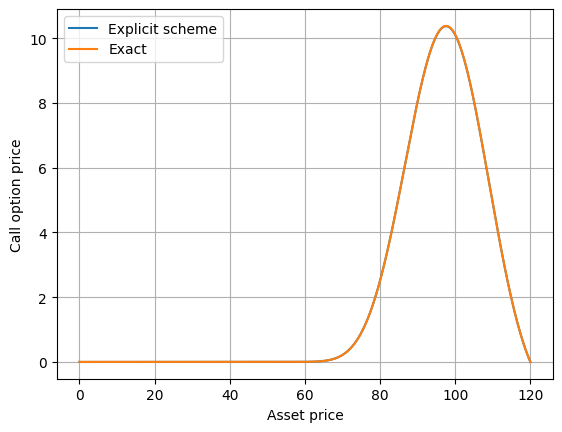

In [ ]:
'''
Task 3.
Solve the black scholes equation for up-and-out call option numerically. Compare with exact price.
'''

def upAndOutCall_explicitSheme(n_x, n_t, T, B, K, s_values):
  u = np.zeros((n_t, n_x))
  h = B / n_x
  tau = T / n_t

  for x in range(n_x):
    u[-1, x] = BSM_payoff(s_values[x], K)

  coeff_1 =  1 - tau * r - tau * sigma**2 * s_values**2 / h**2
  coeff_2 = tau * r * s_values / (2* h) + tau * sigma**2 * s_values**2 / (2*h**2)
  coeff_3 = tau * sigma**2 * s_values**2 / (2*h**2) - tau * r * s_values / (2* h)

  for t in range(n_t - 1, 0, -1):
    for x in range(1, n_x - 1):
      u[t-1, x] = u[t, x] * coeff_1[x] + u[t, x+1] * coeff_2[x] + u[t, x-1] * coeff_3[x]

  return u[0]

n_x, n_t = 1000, 10000
B, K, r, sigma, T = 120, 90, 0.1, 0.1, 1

s_values = np.linspace(0, B, n_x)
s_values[0] = 10**(-5)

UAOC_explicit = upAndOutCall_explicitSheme(n_x, n_t, T, B, K, s_values)
UAOC_exact = np.array([upAndOutCall_exact(r, sigma, s, K, B, T) for s in s_values])
plt.plot(s_values, UAOC_explicit, label='Explicit scheme')
plt.plot(s_values, UAOC_exact, label='Exact')
plt.xlabel("Asset price")
plt.ylabel("Call option price")
plt.grid()
plt.legend()
plt.show()

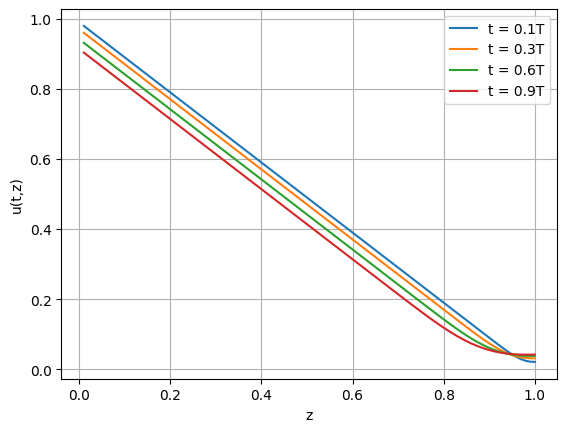

In [ ]:
'''
Task 4.
Compute exact price of lookback option. Draw its plot.
'''

def lookback_option(r, sigma, z, t):
  return (
      (1 + sigma**2 / (2 * r)) * z * norm.cdf(d_plus(r, sigma, t, z))
      + np.exp(- r * t) * norm.cdf(- d_minus(r, sigma, t, z))
      - sigma**2 * np.exp(- r * t) / (2 * r) * z**(1 - 2* r / sigma**2) * norm.cdf(- d_minus(r, sigma, t, z**(-1)))
      - z
  )

r, sigma = 0.1, 0.1
z = np.linspace(0.01, 1, 100)
t_values = [0.1, 0.3, 0.6, 0.9]

for t in t_values:
  LB_exact = np.zeros(len(z))
  for i in range(len(z)):
    LB_exact[i] = lookback_option(r, sigma, z[i], t)
  plt.plot(z, LB_exact, label= f"t = {t}T")

plt.xlabel("z")
plt.ylabel("u(t,z)")
plt.grid()
plt.legend()
plt.show()

In [ ]:
'''
Task 5.
Compute the price of the lookback option by the Monte-Carlo method. Compare with the exact price. 
'''

def BSM(St, r, sigma, dt, z):
    return St * np.exp((r - sigma**2 / 2) * dt + sigma * z * np.sqrt(dt))

def lookbackOption_MonteCarlo(N_trajectory, N_splitting, S0, T, r, sigma):
  S = np.zeros((N_trajectory, N_splitting+1))
  S[:, 0] = S0
  
  for c in range(N_trajectory):
    z = np.random.normal(0, 1, N_splitting)
    for n in range(1, N_splitting+1):
      S[c, n] = BSM(S[c, n - 1], r, sigma, T / N_splitting, z[n-1])

  return np.mean(np.array([(np.max(S[n]) - S[n, -1]) * np.exp(-r * T) for n in range(N_trajectory)])) 

S0, r, sigma, T = 100, 0.1, 0.1, 1
N_splitting, N_trajectory = 1000, 10000

lookback_MC = lookbackOption_MonteCarlo(N_trajectory, N_splitting, S0, T, r, sigma)
LB_price = S0 * lookback_option(r, sigma, 1, T)
print(f"lookback option exact price = {LB_price:.12f}")
print(f"lookback option Monte-Carlo = {lookback_MC:.12f}")
print()

relative_error = abs(LB_price - lookback_MC)/LB_price
print(f"relative_error = {relative_error}")

lookback option exact price = 4.283707529010
lookback option Monte-Carlo = 4.083378159758

relative_error = 0.046765417082117504


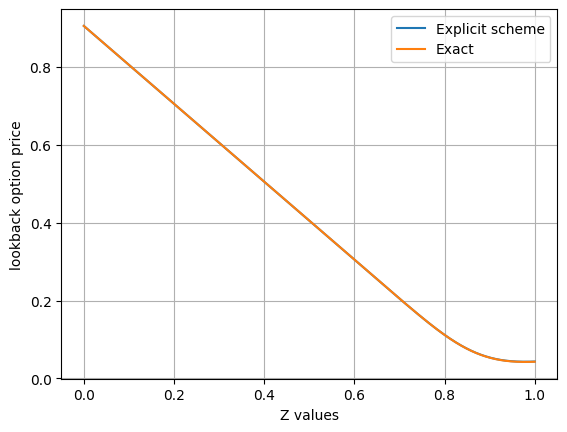

In [ ]:
'''
Task 6.
Solve the black scholes equation for lookback option numerically. Compare with exact price.
'''

def lookback_explicitSheme(n_z, n_t, T, z_values, t_values, r, sigma):
  u = np.zeros((n_t, n_x))
  h = 1 / n_z
  tau = T / n_t

  for t in range(n_t):
    u[t, 0] = np.exp(- r * (T - t_values[t]))
  for z in range(n_z):
    u[-1, z] = 1 - z_values[z]

  coeff_1 =  1 - tau * r - tau * sigma**2 * z_values**2 / h**2
  coeff_2 = tau * r * z_values / (2* h) + tau * sigma**2 * z_values**2 / (2*h**2)
  coeff_3 = tau * sigma**2 * z_values**2 / (2*h**2) - tau * r * z_values / (2* h)

  for t in range(n_t - 1, 0, -1):
    for z in range(1, n_z - 1):
      u[t-1, z] = u[t, z] * coeff_1[z] + u[t, z+1] * coeff_2[z] + u[t, z-1] * coeff_3[z]
    u[t-1, -1] = (1 + h) * u[t-1, -2]
  
  return u[0]

n_z, n_t = 1000, 10000
r, sigma, T = 0.1, 0.1, 1

z_values = np.linspace(0, 1, n_z)
z_values[0] = 10**(-15)
t_values = np.linspace(0, T, n_t)

lookback_explicit = lookback_explicitSheme(n_z, n_t, T, z_values, t_values, r, sigma)
lookback_exact = np.array([lookback_option(r, sigma, z, T) for z in z_values])
plt.plot(z_values, lookback_explicit, label='Explicit scheme')
plt.plot(z_values, lookback_exact, label='Exact')
plt.xlabel("Z values")
plt.ylabel("lookback option price")
plt.grid()
plt.legend()
plt.show()

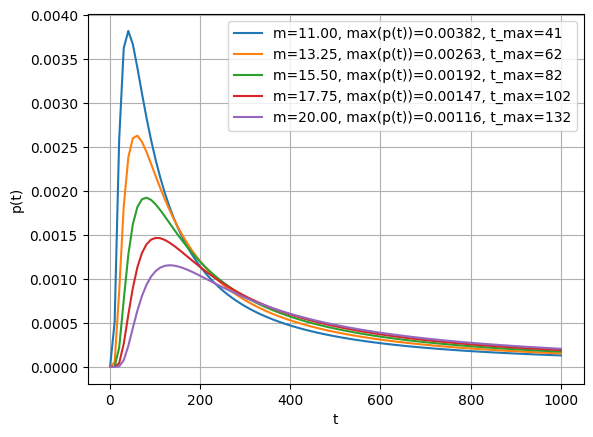

In [ ]:
'''
Task 7. 
Draw plot of density of time to reach the barrier. Find the maximum.
'''

def barrier_density(t, m_values):
  p_t = np.zeros(len(t))
  max_pt = 0
  for i in range(len(t)):
    p_t[i] = m * np.exp(- m**2 / (2 * t[i])) / (t[i] * np.sqrt(2 * np.pi * t[i]))
    if p_t[i] > max_pt:
      argmax_pt = t[i]
      max_pt = p_t[i]
  plt.plot(t, p_t, label=f"m={m:0.2f}, max(p(t))={np.max(p_t):0.5f}, t_max={argmax_pt:0.0f}")

T = 1000
K = 10
t = np.linspace(1, T, 100)
m_values = np.linspace(1.1*K, 2*K, 5)

for m in m_values:
  barrier_density(t, m)
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend()
plt.grid()
plt.show()

0.04678840160444537
explicit = 5.33430, Monte Carlo = 5.31180


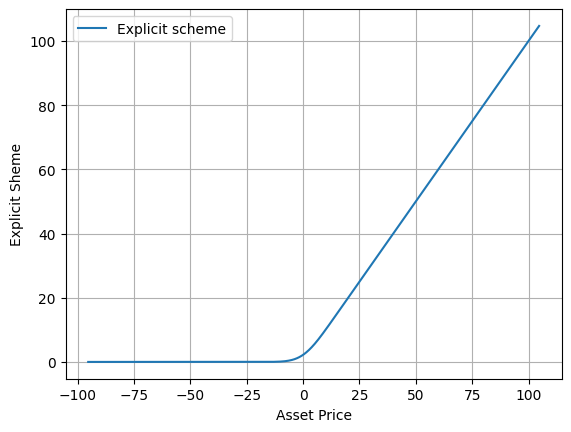

In [ ]:
'''
Task 8. 
'''

def diff_explicitSheme(n_x, n_t, T, x_values, t_values, r, sigma):
  g = np.zeros((n_t, n_x))
  h = (x_values[1] - x_values[0])
  tau = T / n_t

  for x in range(n_x):
    g[-1, x] = max(0, x_values[x])
  for t in range(n_t):
    g[t, -1] = x_values[-1]

  for t in range(n_t - 1, 0, -1):
    gamma_coef = gamma(r, t_values[t], T)
    for x in range(1, n_x - 1):
      coeff_1 =  1 - tau * sigma**2 / h**2 * (gamma_coef - x_values[x])**2
      coeff_2 = tau * sigma**2 / (2*h**2) * (gamma_coef - x_values[x])**2
      g[t-1, x] = g[t, x] * coeff_1 + (g[t, x+1] + g[t, x-1]) * coeff_2
  
  return g[0]

def gamma(r, t, T):
  return (
      1 / (r * T) * (1 - np.exp(- r * (T - t)))
  )

def asian_MonteCarlo(S0, N_trajectory, N_splitting, T, r, sigma, K):
  S = np.zeros((N_trajectory, N_splitting+1))
  S[:, 0] = S0

  for c in range(N_trajectory):
    z = np.random.normal(0, 1, N_splitting)
    for n in range(1, N_splitting+1):
      S[c, n] = BSM(S[c, n - 1], r, sigma, T / N_splitting, z[n-1])

  return ( 
        np.mean(
            [BSM_payoff(s, K) * np.exp(-r * T) 
            for s in np.mean(S[:, 1:], axis=1)])
        )

S0, K, r, sigma, T = 100, 100, 0.1, 0.1, 1
N_splitting, N_trajectory = 100, 10000

x0 = (gamma(r, 0, T) * S0 - K * np.exp(-r * T)) / S0
print(x0)

n_x, n_t = 1000, 10000

x_values = np.linspace(x0-1, x0+1, n_x)
t_values = np.linspace(0, T, n_t)

diff_explicit = S0 * diff_explicitSheme(n_x, n_t, T, x_values, t_values, r, sigma)
asian_explicit = diff_explicit[500]
asian_MC = asian_MonteCarlo(S0, N_trajectory, N_splitting, T, r, sigma, K)
print(f"explicit = {asian_explicit:0.5f}, Monte Carlo = {asian_MC:0.5f}")
plt.plot(x_values * S0, diff_explicit, label='Explicit scheme')
plt.xlabel("Asset Price")
plt.ylabel("Explicit Sheme")
plt.grid()
plt.legend()
plt.show()


In [ ]:
'''
Task 11.
'''

df = pd.read_csv('/content/drive/MyDrive/Colab Data/aapl_2021_2022.csv')
pd.set_option('display.max_columns', None)

col_names = [' [DTE]',
             ' [C_BID]', 
             ' [C_ASK]',
             ' [P_BID]', 
             ' [P_ASK]',
             ' [UNDERLYING_LAST]', 
             ' [STRIKE]',
             ' [C_IV]',
             ' [P_IV]']

df = df.loc[df[' [QUOTE_DATE]']<' 2021-01-07']

for name in col_names:
  df[name].replace(' ', np.nan, inplace=True)
  df.dropna(subset=[name], inplace=True)

df = df[col_names]
df.rename(columns = { 
    ' [DTE]':'ExpirationTime',
    ' [C_BID]':'CallBid', 
    ' [C_ASK]':'CallAsk',
    ' [P_BID]':'PutBid', 
    ' [P_ASK]':'PutAsk',
    ' [UNDERLYING_LAST]':'AssetPrice', 
    ' [STRIKE]':'Strike',
    ' [C_IV]':'CallVolatility',
    ' [P_IV]':'PutVolatility'
    }, inplace = True )

df = df.astype("float64")
df['CallOptionPrice'] = (df['CallBid'] + df['CallAsk']) / 2
df['PutOptionPrice'] = (df['PutBid'] + df['PutAsk']) / 2

df = df.loc[df['ExpirationTime']>0].reset_index(drop=True)
df['ExpirationTime'] = df['ExpirationTime'] / 255

In [ ]:
import scipy.optimize

def d_plus(r, sigma, t, S):
  d = (np.log(S) + (r + np.power(sigma, 2) / 2) * t) / (sigma * np.sqrt(t))
  return d

def d_minus(r, sigma, t, S):
  d = (np.log(S) + (r - np.power(sigma, 2) / 2) * t) / (sigma * np.sqrt(t))
  return d

def BSM_call(sigma):
  r = 0.02
  S = df['AssetPrice']
  T = df['ExpirationTime'] 
  K = df['Strike']
  C = df['CallOptionPrice']
  return S * norm.cdf(d_plus(r, sigma, T, S / K)) - np.exp(-r * T) * K * norm.cdf(d_minus(r, sigma, T, S / K)) - C

def BSM_put(sigma):
  r = 0.02
  S = df['AssetPrice']
  T = df['ExpirationTime'] 
  K = df['Strike']
  C = df['PutOptionPrice']
  return np.exp(-r * T) * K * norm.cdf(- d_minus(r, sigma, T, S / K)) - S * norm.cdf(- d_plus(r, sigma, T, S / K)) - C

sigma_call = scipy.optimize.fsolve(BSM_call, [1 for i in range(df.shape[0])])
sigma_put = scipy.optimize.fsolve(BSM_put, [1 for i in range(df.shape[0])])

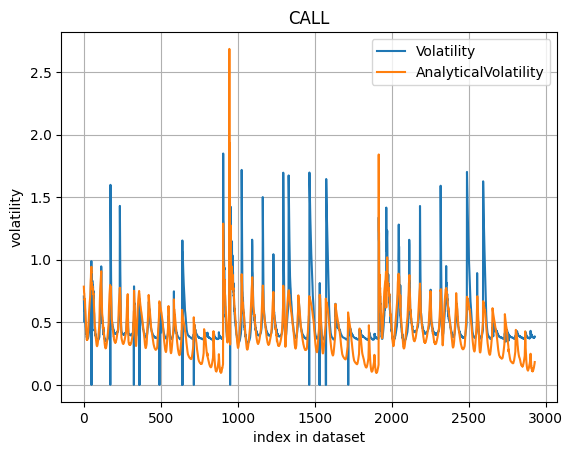

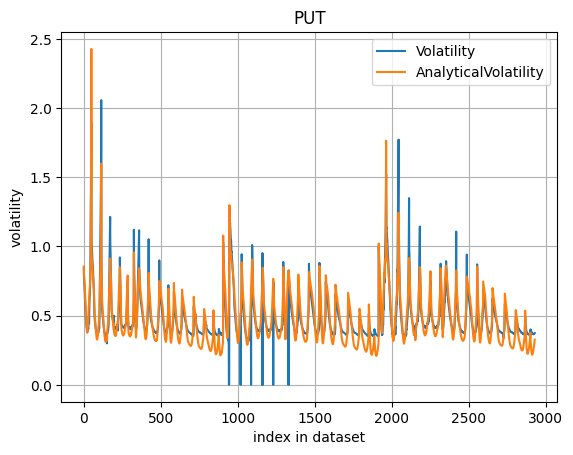

In [ ]:
df_volatility = pd.concat([pd.Series(sigma_call, name='call_iv'), 
                           pd.Series(sigma_put, name='put_iv'), 
                           df[['PutVolatility', 'CallVolatility', 'Strike', 'ExpirationTime']]], axis=1)
# drop noise
df_volatility = df_volatility.loc[
    np.abs(df_volatility['CallVolatility'] - df_volatility['call_iv']) < 1].reset_index(drop=True)
df_volatility = df_volatility.loc[
    np.abs(df_volatility['PutVolatility'] - df_volatility['put_iv']) < 1].reset_index(drop=True)

# precision on the plot
plt.plot(df_volatility['CallVolatility'].index, df_volatility['CallVolatility'], label="Volatility")
plt.plot(df_volatility['CallVolatility'].index, df_volatility['call_iv'], label="AnalyticalVolatility")
plt.grid()
plt.xlabel("index in dataset")
plt.ylabel("volatility")
plt.title("CALL")
plt.legend()
plt.show()

plt.plot(df_volatility['PutVolatility'].index, df_volatility['PutVolatility'], label="Volatility")
plt.plot(df_volatility['PutVolatility'].index, df_volatility['put_iv'], label="AnalyticalVolatility")
plt.grid()
plt.xlabel("index in dataset")
plt.ylabel("volatility")
plt.title("PUT")
plt.legend()
plt.show()


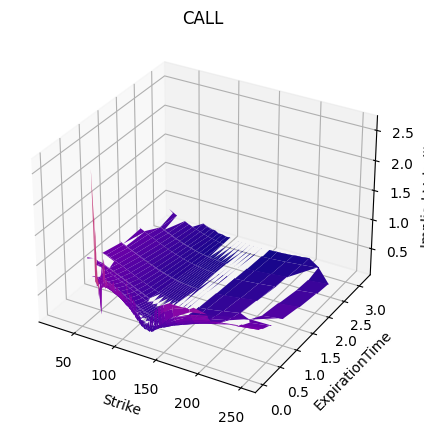

In [ ]:
call_impliedVolatility = df_volatility.pivot(index='Strike', columns='ExpirationTime', values='call_iv')

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(projection='3d')
time, strike = np.meshgrid(call_impliedVolatility.columns, call_impliedVolatility.index)
ax.plot_surface(strike, time, call_impliedVolatility, cmap="plasma")
ax.set_xlabel('Strike')
ax.set_ylabel('ExpirationTime')
ax.set_zlabel('Implied Volatility')
ax.set_title("CALL")
plt.show()

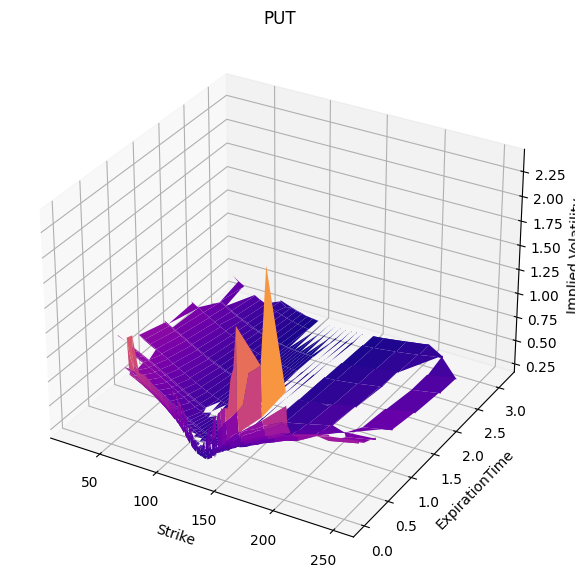

In [ ]:
put_impliedVolatility = df_volatility.pivot(index='Strike', columns='ExpirationTime', values='put_iv')

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(projection='3d')
time, strike = np.meshgrid(put_impliedVolatility.columns, put_impliedVolatility.index)
ax.plot_surface(strike, time, put_impliedVolatility, cmap="plasma")
ax.set_xlabel('Strike')
ax.set_ylabel('ExpirationTime')
ax.set_zlabel('Implied Volatility')
ax.set_title("PUT")
plt.show()

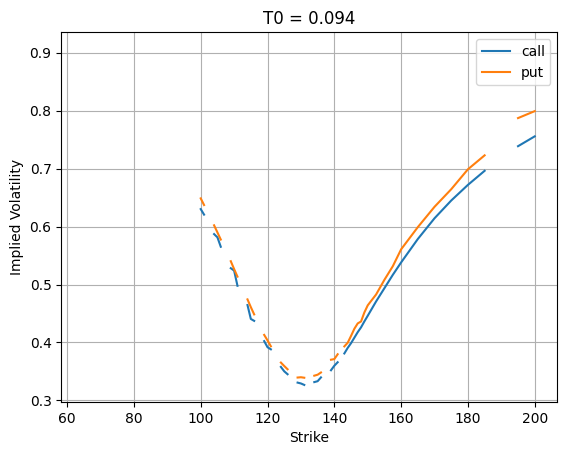

In [ ]:
chosenT = put_impliedVolatility.columns[10]
plt.plot(call_impliedVolatility.index, call_impliedVolatility.iloc[:, 10], label="call")
plt.plot(put_impliedVolatility.index, put_impliedVolatility.iloc[:, 10], label="put")
plt.grid()
plt.title(f"T0 = {chosenT:0.3f}")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()